# 1.) Get and inspect the data
---
I have uploaded the csv file to my github. Download it, define what the columns mean, and look at the header.


In [63]:
import numpy as np
import pandas as pd
url = 'https://raw.githubusercontent.com/andytaylor823/CS-4774-Codeathon-1/master/housing.csv'
colnames = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
'''
1.) CRIM:   per capita crime rate by town
2.) ZN:     proportion of residential land zoned for lots over 25k sq. ft.
3.) INDUS:  proportion of non-retail business acres per town
4.) CHAS:   =1 if tract bounds Charles River, =0 otherwise
5.) NOX:    nitric oxides concentration (ppm)
6.) RM:     avg number of rooms per dwelling
7.) AGE:    fraction of owner-occupied units built before 1940
8.) DIS:    weighted distances to 5 Boston employment centers
9.) RAD:    index of accessibility fo radial highways
10.) TAX:   full-value property-tax rate per $10,000
11.) PTRATIO: pupil-teacher ratio by town
12.) B:     1000*(frac-0.63)^2, where "frac" is the fraction of African-Americans by town
13.) LSTAT: percent lower status of the population (what?)
14.) MEDV:  median value of owner-occupied homes in units of $1000s
'''
df = pd.read_csv(url, sep=',', names=colnames)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Use ".info()" and ".describe()" to take a closer look at the data

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       452 non-null float64
dtypes: float64(13), int64(1)
memory usage: 55.5 KB


In [65]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,452.000000
mean,1.269195,13.295257,9.205158,0.140765,1.101175,15.679800,58.744660,6.173308,78.063241,339.317787,42.614980,332.791107,11.537806,23.750442
std,2.399207,23.048697,7.169630,0.312765,1.646991,27.220206,33.104049,6.476435,203.542157,180.670077,87.585243,125.322456,6.064932,8.808602
min,0.000000,0.000000,0.000000,0.000000,0.385000,3.561000,1.137000,1.129600,1.000000,20.200000,2.600000,0.320000,1.730000,6.300000
25%,0.049442,0.000000,3.440000,0.000000,0.449000,5.961500,32.000000,2.430575,4.000000,254.000000,17.000000,364.995000,6.877500,18.500000
50%,0.144655,0.000000,6.960000,0.000000,0.538000,6.322500,65.250000,3.925850,5.000000,307.000000,18.900000,390.660000,10.380000,21.950000
75%,0.819622,18.100000,18.100000,0.000000,0.647000,6.949000,89.975000,6.332075,24.000000,403.000000,20.200000,395.615000,15.015000,26.600000
max,9.966540,100.000000,27.740000,1.000000,7.313000,100.000000,100.000000,24.000000,666.000000,711.000000,396.900000,396.900000,34.410000,50.000000


Seems like we're missing some values from the the MEDV column. Looking ahead, this will likely be the column we want our model to predict, so it's a big deal to be missing some data here.

On another note, the "B" column seems to be burying the real variable. The real variable seems to be the black fraction of the population, but this is hidden for some reason. Let's create a "BFRAC" column showing the real variable and drop the old, confusing "B" column.

In [0]:
df['BFRAC'] = 0.63 - np.sqrt(df['B']/1000)
df.drop('B', axis=1, inplace=True)

Additionally, because there are so many regions that are not zoned (have "ZN" = 0), that I will add a new column called "ISZND", denoting whether or not the region is zoned at all.

In [0]:
df['ISZND'] = (df['ZN']!=0).astype(int)

Now that we've taken care of that, let's visually inspect the data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa01acd0ba8>,
      dtype=object)

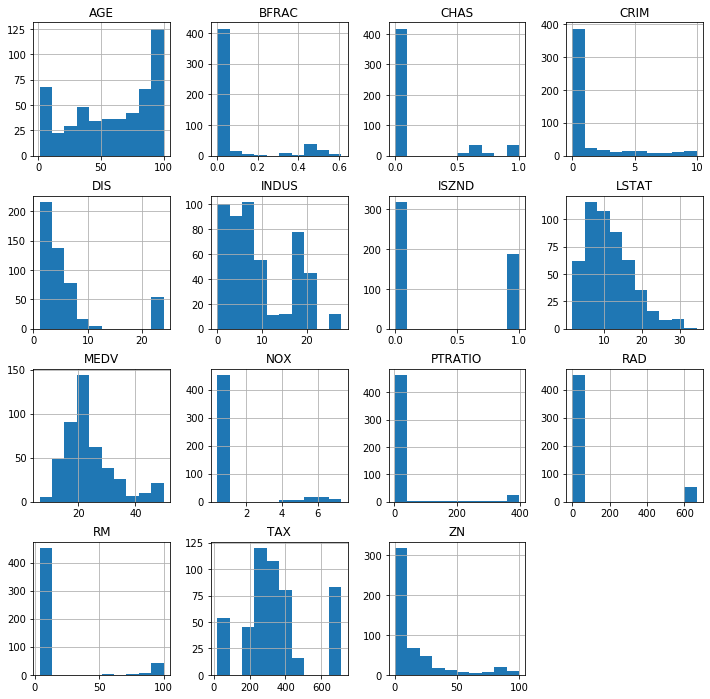

In [68]:
df.hist(figsize=(12,12))

There are several important things to notice here:

1.) "CHAS" is supposed to be either 0 or 1, denoting if the tract borders the Charles River, but there are some decimal values in the data.

2.) The "MEDV" data is not quite normally distributed--we'll get to that later.

3.) The "NOX" data is mostly in between 0 and 1, with a few outliers. That seems odd.

4.) The "PTRATIO" data has some very odd values (does it make sense for the ratio of students to teachers to be over 200?).

5.) Similarly, "RAD" and "RM" are skewed by outliers.

What do we do about (3) - (5)? Let's look at some of these odd data and see if we can find an explanation.

54


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa01a8dfa90>,
      dtype=object)

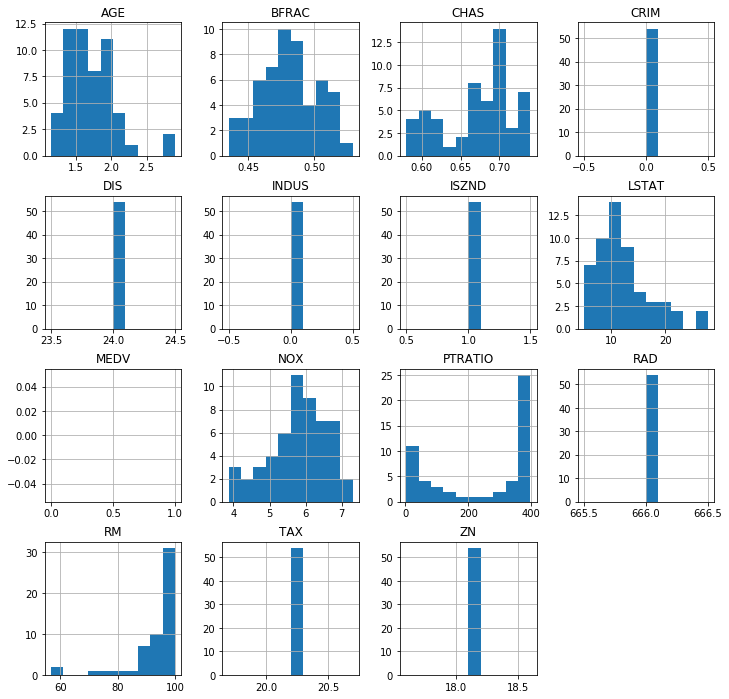

In [69]:
odd_data_nox = df[df.NOX > 2]
print(len(odd_data_nox))
odd_data_nox.hist(figsize=(12,12))

Okay, I think we are getting some answers from this. There are 54 data points in this selection of data, and there are exactly 54 data points in the entire dataset with missing MEDV values. The above MEDV histogram is blank, indicating that none of the selected data points have a MEDV value filled in. Thus, the odd "NOX" data corresponds to data missing a MEDV value.

If we find that the other odd data from before is also all the data missing the MEDV values, we may simply have some bad data points. Let's see how many data points fit into the "odd data" we described before.

In [70]:
mask_missing_MEDV = df['MEDV'].isna()
mask_odd_RAD = df['RAD'] > 50
mask_odd_RM = df['RM'] > 20
mask_odd_CHAS = (df['CHAS']!=0) & (df['CHAS']!=1)
mask_odd_PTRATIO = df['PTRATIO'] > 50

# number of odd RAD points and number of odd RAD points missing MEDV vals
print(sum(mask_odd_RAD), sum((mask_odd_RAD) & (mask_missing_MEDV)))
# number of odd RM points and number of odd RM points missing MEDV vals
print(sum(mask_odd_RM), sum((mask_odd_RM) & (mask_missing_MEDV)))
# number of odd CHAS points and number of odd CHAS points missing MEDV vals
print(sum(mask_odd_CHAS), sum((mask_odd_CHAS) & (mask_missing_MEDV)))
# number of odd PTRATIO points and number of odd PTRATIO points missing MEDV vals
print(sum(mask_odd_PTRATIO), sum((mask_odd_PTRATIO) & (mask_missing_MEDV)))

54 54
54 54
54 54
41 41


It seems like we can prettly definitively say that the odd data points are caused by the regions also missing MEDV values. Though not all points with missing MEDV values have odd PTRATIO values, every point with an odd PTRATIO value is missing a MEDV value. Thus, this data will likely not help the accuracy of our model, so we drop all data points with missing MEDV values.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa01a075208>,
      dtype=object)

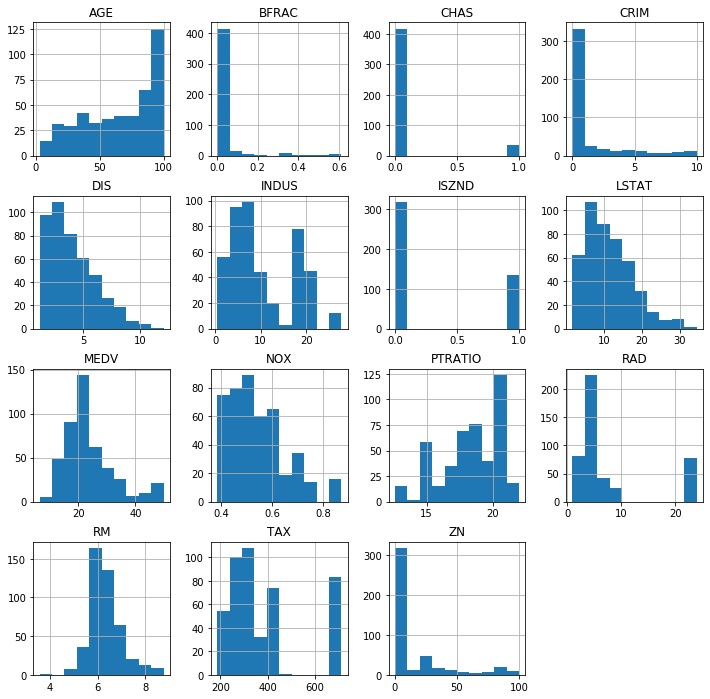

In [71]:
df.dropna(axis=0, subset=['MEDV'], inplace=True)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df.hist(figsize=(12,12))

That looks much better. Now, before we go too much further, let's split the data into training and testing sets.

# 2.) Splitting the data
---
As in the example with the California data, we want to split the data stratified according to the median value of the homes. The MEDV data is not quite normally distributed, as the number of regions slightly increases at the upper tail of the MEDV distribution. Let us stratify the MEDV columns into roughly normal-looking sections.

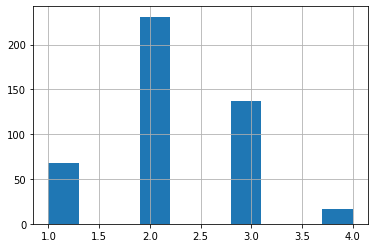

In [72]:
df['val_cat'] = pd.cut(df['MEDV'],
                       bins=[0., 16, 24, 49, np.inf],
                       labels = [1,2,3,4])
df['val_cat'].hist()

Now with this roughly normal data, we split the datset up into training and testing.

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=682935)
for train_index, test_index in split.split(df, df["val_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [74]:
from sklearn.model_selection import train_test_split
def val_cat_proportions(data):
    return data["val_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": val_cat_proportions(df),
    "Stratified": val_cat_proportions(strat_test_set),
    "Random": val_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.150442,0.153846,0.175824,16.871364,2.262443
2,0.511062,0.505495,0.483516,-5.389848,-1.089387
3,0.303097,0.307692,0.307692,1.516002,1.516002
4,0.035398,0.032967,0.032967,-6.868132,-6.868132


We see that the training and test sets are slightly more representative of the actual dataset by using the stratified splitting than a random split. Having split the data into "strat_test_set" and "strat_train_set", we drop the "val_cat" column from both.

In [0]:
for set_ in (strat_test_set, strat_train_set):
  set_.drop('val_cat', axis=1, inplace=True)
train = strat_train_set.copy()
test = strat_test_set.copy()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa019958978>,
      dtype=object)

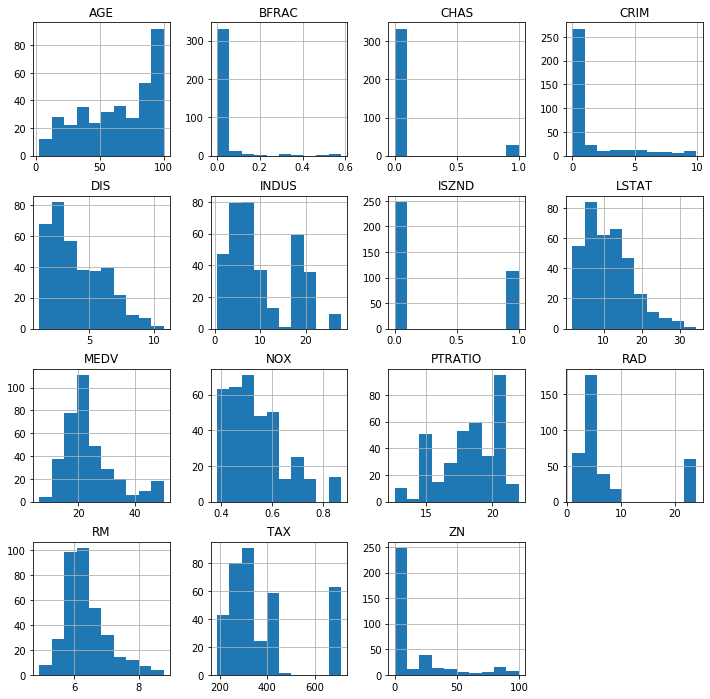

In [76]:
train.hist(figsize=(12,12))

# 3.) Check correlation matrix
---
Let's look at the correlation matrix to see which variables tend to go best with MEDV

In [77]:
corr_matrix = train.corr()
corr_matrix['MEDV'].sort_values(ascending=False)

MEDV       1.000000
RM         0.783767
ISZND      0.323095
ZN         0.320995
CHAS       0.157806
DIS        0.141244
RAD       -0.240608
BFRAC     -0.257606
AGE       -0.301856
CRIM      -0.318292
NOX       -0.346347
TAX       -0.354674
INDUS     -0.405691
PTRATIO   -0.476745
LSTAT     -0.711185
Name: MEDV, dtype: float64

Do the same thing, but make a cool-looking heatmap!

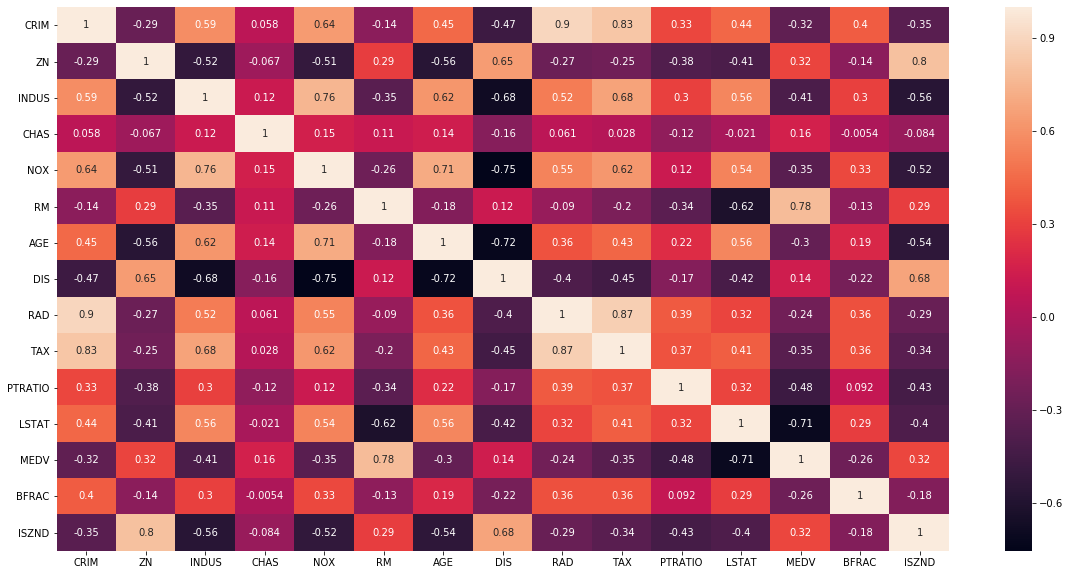

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True)

We see that MEDV is most strongly correlated with RM (houses with greater avg number of rooms are usually larger, more expensive) and is most strongly anti-correlated with LSTAT (regions with more poor people are less likely to have high-value homes). The next strongest anti-correlation is with the PTRATIO; regions with fewer teachers per student (high PTRATIO) are likely to be poorer regions. So far, all the correlations follow intuition.

# 4.) Construct a pipeline
---
The data are mostly pretty cleaned, so we will not need to build much of a pipeline. We mainly just need to StandardScale the numerical data, while not touching the categorical columns (namely CHAS). First, we break the training data up into X_train and y_train.

In [0]:
X_train = train.drop('MEDV', axis=1)
y_train = train['MEDV'].copy()

Next, we split the X_train data into numerical and categorical subsets.

In [0]:
X_train_num = X_train.drop(['CHAS','ISZND'], axis=1)
X_train_cat = X_train[['CHAS', 'ISZND']].copy()

Next, we build a Pipeline to StandardScale all the numerical columns while ignoring the categorical one.

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
])
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, X_train_num.columns),
    ('cat', 'passthrough', ['CHAS', 'ISZND'])
])
X_train_full = full_pipeline.fit_transform(X_train)

# 5.) Select and train a model
---
I will test three separate models (LinearRegression, DecisionTreeRegressor, RandomForestRegressor) using 5-fold CV. For each model, I (1) import the relevant sklearn package, (2) fit the data to the model, (3) compute 5-fold CV, and (4) print out the errors.

Before I begin, though, let me define a function to print out all the scores from CV.

In [0]:
def display_scores(s):
  print('Scores:', s)
  print('Mean:', np.average(s))
  print('Standard Deviation:', np.std(s))

Now, I begin with the LinearRegression model.

In [83]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_full, y_train)

scores = cross_val_score(linreg, X_train_full, y_train,
                         scoring='neg_mean_squared_error', cv=5)
lin_scores = np.sqrt(-scores)
display_scores(lin_scores)

Scores: [3.42996296 4.59946901 5.83918357 4.62635329 4.23871335]
Mean: 4.546736436694539
Standard Deviation: 0.7773802636769159


Next, I move on to a DecisionTreeRegressor model

In [84]:
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=623)
treereg.fit(X_train_full, y_train)

scores = cross_val_score(treereg, X_train_full, y_train,
                         scoring='neg_mean_squared_error', cv=5)
tree_scores = np.sqrt(-scores)
display_scores(tree_scores)

Scores: [4.47876267 4.49922833 6.47249523 6.49346894 4.40476384]
Mean: 5.269743800474506
Standard Deviation: 0.9911256013875371


Finally, a RandomForestRegressor model

In [85]:
from sklearn.ensemble import RandomForestRegressor
forestreg = RandomForestRegressor(random_state=623)
forestreg.fit(X_train_full, y_train)

scores = cross_val_score(forestreg, X_train_full, y_train,
                         scoring='neg_mean_squared_error', cv=5)
forest_scores = np.sqrt(-scores)
display_scores(forest_scores)

Scores: [3.23131379 3.65624759 4.60073382 4.55070627 2.78550513]
Mean: 3.764901323210978
Standard Deviation: 0.7171950313910117


It looks like the RFR model is best, followed by the LR model, and the DTR model is worst. Next, we move onto tuning the hyperparameters of this model.

# 6.) Tuning the hyperparameters
---
I could spend the time creating my own hyperparameter grid and searching through that, but I would rather do a random search over the grid. So, instead of using GridSearchCV, I'll just skip straight ahead to RandomizedSearchCV.

In [86]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_distributions = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=13)
}
rnd_search = RandomizedSearchCV(forestreg, param_distributions=param_distributions,
                                n_iter=30, cv=5, scoring='neg_mean_squared_error', random_state=623)
rnd_search.fit(X_train_full, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

Store the results and show the top 10 sets of parameters

In [87]:
cvres = rnd_search.cv_results_
scores_and_params = zip(np.sqrt(-cvres['mean_test_score']), cvres['params'])
sorted_snp = sorted(scores_and_params)
for i in range(10):
  print(sorted_snp[i])

(3.3679128255925743, {'max_features': 6, 'n_estimators': 195})
(3.3689641632157166, {'max_features': 4, 'n_estimators': 162})
(3.3725475603837785, {'max_features': 4, 'n_estimators': 144})
(3.3795412942585084, {'max_features': 5, 'n_estimators': 55})
(3.3855991555867333, {'max_features': 5, 'n_estimators': 118})
(3.391559610419535, {'max_features': 4, 'n_estimators': 70})
(3.3929908369894384, {'max_features': 6, 'n_estimators': 98})
(3.393927604222171, {'max_features': 7, 'n_estimators': 153})
(3.3999050727727522, {'max_features': 4, 'n_estimators': 99})
(3.433311169003619, {'max_features': 7, 'n_estimators': 65})


The best set of parameters

In [88]:
rnd_search.best_params_

{'max_features': 6, 'n_estimators': 195}

Show the most important features from the best model

In [89]:
best_model = rnd_search.best_estimator_
sorted(zip(best_model.feature_importances_, X_train.columns), reverse=True)

[(0.3850384632815762, 'NOX'),
 (0.31038639782630995, 'PTRATIO'),
 (0.06042133677586488, 'INDUS'),
 (0.04742428296989746, 'TAX'),
 (0.03969497042323849, 'AGE'),
 (0.03322213273705901, 'CHAS'),
 (0.033096690895311164, 'RM'),
 (0.031129300392426694, 'CRIM'),
 (0.023490143646027098, 'RAD'),
 (0.019786763370645947, 'LSTAT'),
 (0.007471569670666557, 'DIS'),
 (0.005966845761076599, 'ZN'),
 (0.0018323359579047996, 'BFRAC'),
 (0.0010387662919952875, 'ISZND')]

Huh, so it looks like the "NOX" column (corresponding to the concentration of nitrous oxides) seems to be a very important predictor of housing prices! Without knowing more about the situation, I cannot speculate as to why this is the case.

Next most important is the ratio of pupils to teachers, which makes sense; people are willing to pay more to live in a place with a good school system.

# 7.) Deploying the model
Now, we move onto the final step: deploying the model on the testing data and assessing our results. We pipe the test data through the pipeline, then use the best model from our random search to evaluate the testing data.

In [90]:
from sklearn.metrics import mean_squared_error
X_test = strat_test_set.drop('MEDV', axis=1)
y_test = strat_test_set['MEDV'].copy()
X_test_full = full_pipeline.fit_transform(X_test)

final_predictions = best_model.predict(X_test_full)
final_mse = mean_squared_error(final_predictions, y_test)
final_rmse = np.sqrt(final_mse)
final_rmse

4.982321472689879

Looks like our RMSE is about 5, meaning that the average error on our estimate of a house's value is about \$5,000. Most homes cost around \$25,000, so our error is roughly 20\% of the average home's value. This isn't great, but we had a very small sample size of data, containing only around 450 entries.

As a final look at the predictions of our model, let us compare histograms of the actual and predicted results:

Text(0.5, 0, 'Median home values ($1,000)')

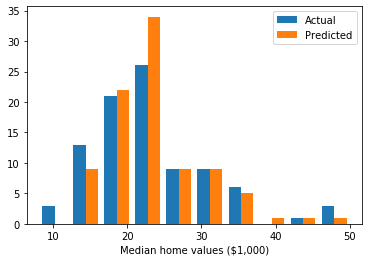

In [91]:
plt.hist([y_test, final_predictions], label = ['Actual', 'Predicted'])
plt.legend()
plt.xlabel('Median home values ($1,000)')